In [52]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from catboost import CatBoostClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
from imblearn.over_sampling import SMOTE
from tabpfn import TabPFNClassifier
import torch

In [53]:
df = pd.read_csv('processed-data.csv')

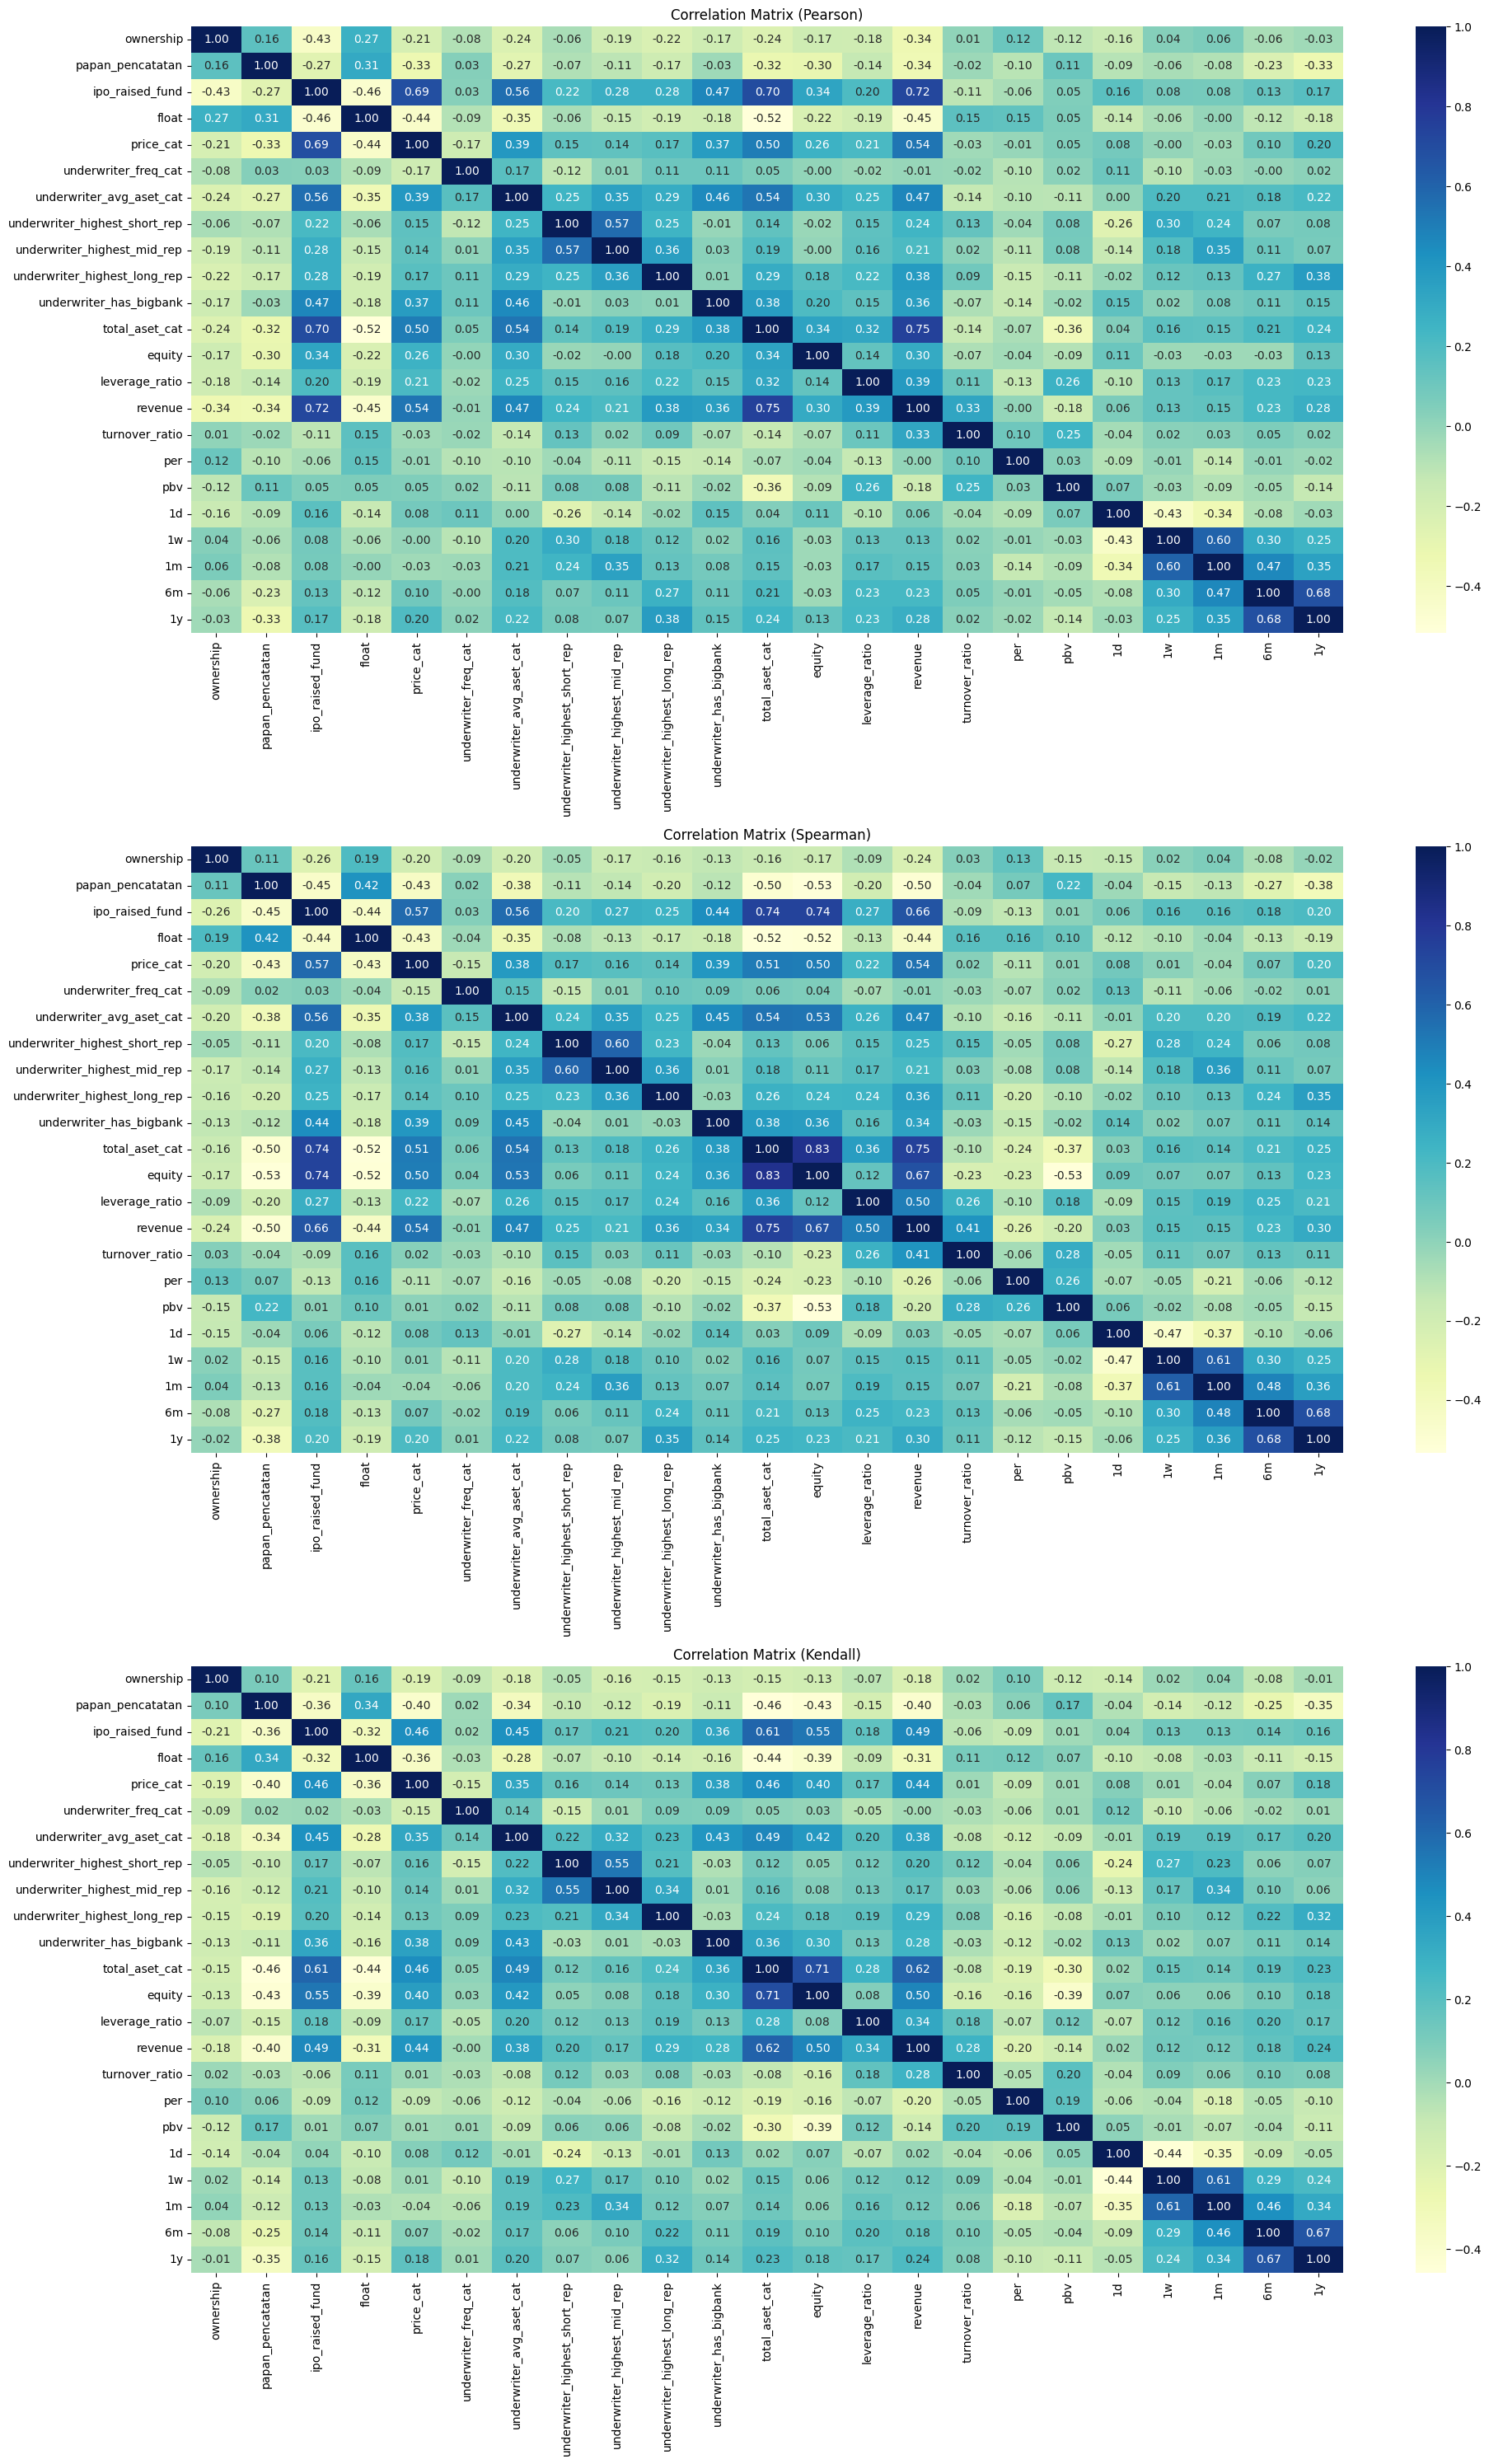

In [54]:
corr_methods = ['pearson', 'spearman', 'kendall']
plt.figure(figsize=(20, 10 * len(corr_methods)))

for i, method in enumerate(corr_methods, 1):
    plt.subplot(len(corr_methods), 1, i)
    corr = df.iloc[:].corr(method=method)
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='YlGnBu', cbar=True)
    plt.title(f'Correlation Matrix ({method.title()})')

plt.tight_layout()
plt.show()

In [55]:
df[['equity', 'per', 'pbv', 'turnover_ratio']].describe()

,equity,per,pbv,turnover_ratio
count,223.000000,223.000000,223.000000,223.000000
mean,25.580147,2.423796,5.276668,0.427654
std,4.349184,3.337046,3.154391,0.375850
min,-33.151009,-10.402530,-0.002504,0.000778
25%,24.625129,2.571958,2.517265,0.174251
50%,25.386705,3.765674,4.649522,0.329517
75%,26.919770,4.615121,8.346717,0.632160
max,32.500861,4.615121,10.000000,2.797158


In [56]:
# df_clean = df.copy()

# pbv_thresh = 15                      # super high PBV
# log_per_upper = np.log(200)          # allow PER up to 200
# log_turnover_thresh = np.log(500)    # super speculative turnover
# log_equity_thresh = np.log(1e10)     # allow microcaps, block only near-zero equity

# gorengan_mask = (
#     (df_clean['pbv'] > pbv_thresh) |
#     (df_clean['per'] > log_per_upper) |
#     (df_clean['per'] < 0) | 
#     (df_clean['turnover_ratio'] > log_turnover_thresh) |
#     (df_clean['equity'] < log_equity_thresh)
# )

# df_clean = df_clean[~gorengan_mask].reset_index(drop=True)

# print(f"Removed {gorengan_mask.sum()} potential 'saham gorengan'.")
# print(f"Remaining: {len(df_clean)} rows.")

# df = df_clean


Code untuk mencari fitur dengan korelasi minimal `threshold`, dengan mencegah adanya dua fitur yang terlalu mirip, sehingga mencegah overfitting

In [57]:
def select_features_by_kendall(df, target_cols, threshold=0.075, max_features=8, corr_cutoff=0.7):
    corr_matrix = df.corr(method="kendall")

    selected_features_per_target = {}

    for target in target_cols:
        if target not in df.columns:
            continue

        features_only = [col for col in df.columns if col not in target_cols and col != target]
        
        target_corr = corr_matrix.loc[features_only, target]
        
        top_features = target_corr[abs(target_corr) >= threshold].sort_values(ascending=False)

        selected = []
        for feature in top_features.index:
            too_correlated = any(
                abs(corr_matrix.loc[feature, sel]) > corr_cutoff
                for sel in selected
            )
            if not too_correlated:
                selected.append(feature)
            if len(selected) >= max_features:
                break

        selected_features_per_target[target] = selected

    return selected_features_per_target


In [58]:
targets = ["1d", "1w", "1m", "6m", "1y"]

selected_features = select_features_by_kendall(df, targets)

for target, features in selected_features.items():
    print(f"Target: {target} -> Features: {features}")

Target: 1d -> Features: ['underwriter_has_bigbank', 'underwriter_freq_cat', 'price_cat', 'float', 'underwriter_highest_mid_rep', 'ownership', 'underwriter_highest_short_rep']
Target: 1w -> Features: ['underwriter_highest_short_rep', 'underwriter_avg_aset_cat', 'underwriter_highest_mid_rep', 'total_aset_cat', 'ipo_raised_fund', 'revenue', 'leverage_ratio', 'underwriter_highest_long_rep']
Target: 1m -> Features: ['underwriter_highest_mid_rep', 'underwriter_highest_short_rep', 'underwriter_avg_aset_cat', 'leverage_ratio', 'total_aset_cat', 'ipo_raised_fund', 'revenue', 'underwriter_highest_long_rep']
Target: 6m -> Features: ['underwriter_highest_long_rep', 'leverage_ratio', 'total_aset_cat', 'revenue', 'underwriter_avg_aset_cat', 'ipo_raised_fund', 'underwriter_has_bigbank', 'underwriter_highest_mid_rep']
Target: 1y -> Features: ['underwriter_highest_long_rep', 'revenue', 'total_aset_cat', 'underwriter_avg_aset_cat', 'price_cat', 'leverage_ratio', 'ipo_raised_fund', 'underwriter_has_bigba

> Training - TabPFN

#### training - 1day

In [59]:
feature_cols = ['underwriter_has_bigbank', 'underwriter_freq_cat', 'price_cat', 'float', 'underwriter_highest_mid_rep', 'ownership', 'underwriter_highest_short_rep']

X = df[feature_cols]
y = df['1d']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=5)


Accuracy: 0.6222222222222222
              precision    recall  f1-score   support

           0       0.59      0.96      0.73        24
           1       1.00      0.44      0.62         9
           2       0.50      0.08      0.14        12

    accuracy                           0.62        45
   macro avg       0.70      0.50      0.50        45
weighted avg       0.65      0.62      0.55        45



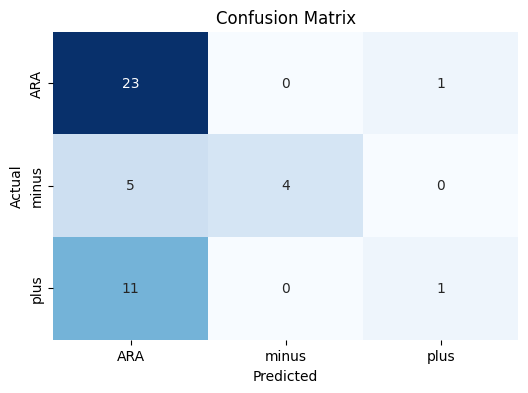

In [60]:
# classifier
clf = TabPFNClassifier(device='cuda' if torch.cuda.is_available() else 'cpu')

# fit n predict
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# eval
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# {'ARA': 0, 'minus': 1, 'plus': 2}

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['ARA', 'minus', 'plus'],
            yticklabels=['ARA', 'minus', 'plus'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#### training - 1 week

In [61]:
feature_cols = ['underwriter_highest_short_rep', 'underwriter_avg_aset_cat', 'underwriter_highest_mid_rep', 'total_aset_cat', 'ipo_raised_fund', 'revenue', 'leverage_ratio', 'underwriter_highest_long_rep']

X = df[feature_cols]
y = df['1w']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=5)

Accuracy: 0.7111111111111111
              precision    recall  f1-score   support

           0       1.00      0.24      0.38        17
           1       0.68      1.00      0.81        28

    accuracy                           0.71        45
   macro avg       0.84      0.62      0.60        45
weighted avg       0.80      0.71      0.65        45



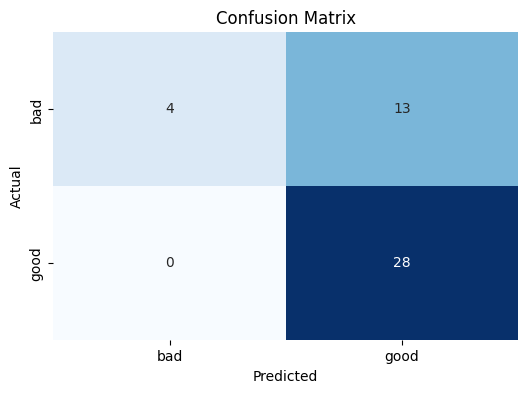

In [62]:
# classifier
clf = TabPFNClassifier(device='cuda' if torch.cuda.is_available() else 'cpu')

# fit n predict
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# eval
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['bad', 'good'],
            yticklabels=['bad', 'good'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#### training - 1month

In [63]:
feature_cols = ['underwriter_highest_mid_rep', 'underwriter_highest_short_rep', 'underwriter_avg_aset_cat', 'leverage_ratio', 'total_aset_cat', 'ipo_raised_fund', 'revenue', 'underwriter_highest_long_rep']

X = df[feature_cols]
y = df['1m']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=5)

Accuracy: 0.7555555555555555
              precision    recall  f1-score   support

           0       0.75      0.71      0.73        21
           1       0.76      0.79      0.78        24

    accuracy                           0.76        45
   macro avg       0.76      0.75      0.75        45
weighted avg       0.76      0.76      0.76        45



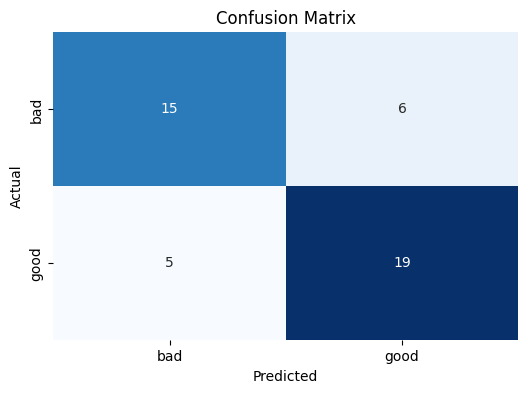

In [64]:
# classifier
clf = TabPFNClassifier(device='cuda' if torch.cuda.is_available() else 'cpu')

# fit n predict
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# eval
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['bad', 'good'],
            yticklabels=['bad', 'good'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#### training - 6months

In [65]:
feature_cols = ['underwriter_highest_long_rep', 'leverage_ratio', 'total_aset_cat', 'revenue', 'underwriter_avg_aset_cat', 'ipo_raised_fund', 'underwriter_has_bigbank', 'underwriter_highest_mid_rep']

X = df[feature_cols]
y = df['6m']

mask = y != 1
X = X[mask]
y = y[mask]

y = y.replace({2: 1})

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=5)

Accuracy: 0.6341463414634146
              precision    recall  f1-score   support

           0       0.62      0.82      0.71        22
           1       0.67      0.42      0.52        19

    accuracy                           0.63        41
   macro avg       0.64      0.62      0.61        41
weighted avg       0.64      0.63      0.62        41



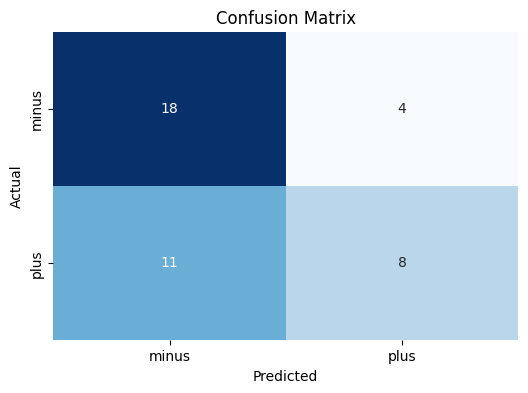

In [66]:
# classifier
clf = TabPFNClassifier(device='cuda' if torch.cuda.is_available() else 'cpu')

# fit n predict
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# eval
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['minus', 'plus'],
            yticklabels=['minus', 'plus'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#### training - 1year

In [67]:
feature_cols = ['underwriter_highest_long_rep', 'revenue', 'total_aset_cat', 'underwriter_avg_aset_cat', 'price_cat', 'leverage_ratio', 'ipo_raised_fund', 'underwriter_has_bigbank']

X = df[feature_cols]
y = df['1y']

mask = y != 1
X = X[mask]
y = y[mask]

y = y.replace({2: 1})
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=5)

Accuracy: 0.8461538461538461
              precision    recall  f1-score   support

           0       0.80      1.00      0.89        24
           1       1.00      0.60      0.75        15

    accuracy                           0.85        39
   macro avg       0.90      0.80      0.82        39
weighted avg       0.88      0.85      0.84        39



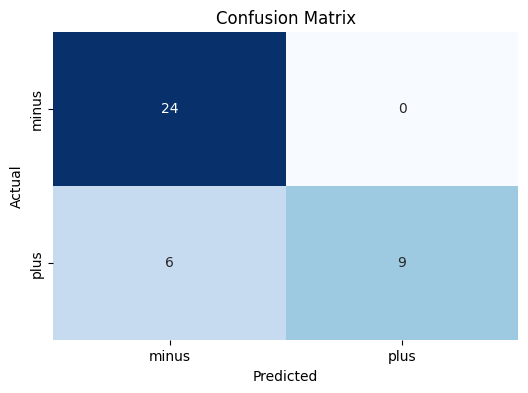

In [68]:
# classifier
clf = TabPFNClassifier(device='cuda' if torch.cuda.is_available() else 'cpu')

# fit n predict
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# eval
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['minus', 'plus'],
            yticklabels=['minus', 'plus'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()